In [1]:
import os
from glob import glob
import nibabel as nib
from scipy.spatial.distance import dice
import numpy as np
import itk
import SimpleITK as sitk
import scipy.ndimage
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from nilearn.reporting import make_glm_report
from nilearn.glm.second_level import SecondLevelModel
from nilearn import plotting
from nilearn.glm import threshold_stats_img

In [2]:
from nilearn.plotting import plot_design_matrix
mouses_filename = os.path.join('dataset2', 'Feminad', 'feminad.csv')
mouses_csv = pd.read_csv(mouses_filename)
male = mouses_csv['sex'] == 'M'
female = mouses_csv['sex'] == 'F'
age1 = mouses_csv['age'] == '2mois'
age2 = mouses_csv['age'] == '12mois'
m2 = male * age1
m12 = male * age2
f2 = female * age1
f12 = female * age2

33


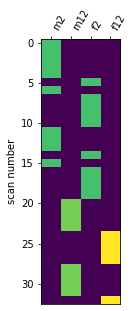

In [3]:
design_matrix = pd.DataFrame(np.vstack((m2, m12, f2, f12)).T,
                             columns=['m2', 'm12', 'f2', 'f12'])
#design_matrix = design_matrix[:5]
ax = plot_design_matrix(design_matrix)
print(len(design_matrix))

output/Feminad/DL_Scenario10/Log10Jacobian_Deformable/Log10JacobianDeformable_Affine_Identity_Norm_Resampled_N4_12_6517.nii.gz


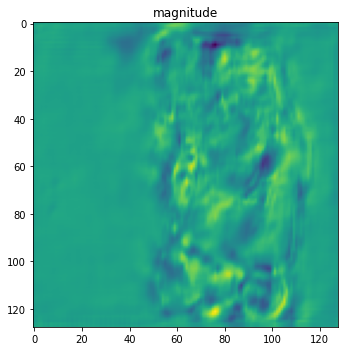

In [4]:
log_filenames = sorted(glob(os.path.join('output', 'Feminad', 'DL_Scenario10', 'Log10Jacobian_Deformable', "*.nii.gz")))
for file in log_filenames:
    print(file)
    log10 = nib.load(file).get_fdata()    
    i = log10.shape[0]//2
    dat = (log10[i,:,:])
    plt.figure("Jacobian", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("magnitude")    
    plt.imshow(dat)
    plt.show()
    plt.show()
    break

In [5]:
atlas_mri = os.path.join('dataset2', 'Atlas', 'Deformable_Feminad_template0_sameaffine.nii.gz')
mask_img = nib.load(os.path.join('dataset2', 'Atlas', 'Deformable_Feminad_Mask_template0_sameaffine.nii.gz'))
second_level_model = SecondLevelModel(smoothing_fwhm=0.5, mask_img=mask_img)
second_level_model.fit(log_filenames,
                       design_matrix=design_matrix)

SecondLevelModel(mask_img=<nibabel.nifti1.Nifti1Image object at 0x7ff072c17a00>,
                 smoothing_fwhm=0.5)

In [6]:
thresholds_dict = { 
                'fdr005': ('fdr', 0.05),
                'fpr001': ('fpr', 0.01),  
                'fpr005': ('fpr', 0.05),
            }

contrasts_dict = {
    'age'    : [-1, 1, -1, 1],
    'age-M'  : [-1, 1, 0, 0],
    'age-F'  : [0, 0, -1, 1],
    'sex'    : [-1, -1, 1, 1],
    'sex-2m' : [-1, 0, 1, 0],
    'sex-12m': [0, -1, 0, 1],
}

In [7]:
#import traceback
#import warnings
#import sys
#
#warnings.simplefilter("always")
#
#def warn_with_traceback(message, category, filename, lineno, file=None, line=None):
#
#    log = file if hasattr(file,'write') else sys.stderr
#    traceback.print_stack(file=log)
#    log.write(warnings.formatwarning(message, category, filename, lineno, line))
#    print('-'*30)
#
#warnings.showwarning = warn_with_traceback

In [8]:
for heights, values in thresholds_dict.items():
    report = make_glm_report(model=second_level_model,
                                 contrasts=contrasts_dict,
                                 bg_img=atlas_mri,
                                 height_control=values[0],
                                 alpha=values[1],
                                 display_mode='z'
                                 )
    report.save_as_html(os.path.join('output', 'Feminad', 'DL_Trilinear', 'Reports-Deformable', 'report_deformable_feminad_' + str(heights) + '.html'))

The given float value must not exceed 4.452032688499856. But, you have given threshold=inf 
empty mask
The given float value must not exceed 4.452032688499856. But, you have given threshold=inf 
Attention: No clusters with stat higher than inf
The given float value must not exceed 3.72897095431453. But, you have given threshold=inf 
empty mask
The given float value must not exceed 3.72897095431453. But, you have given threshold=inf 
Attention: No clusters with stat higher than inf
The given float value must not exceed 4.776710827486588. But, you have given threshold=inf 
empty mask
The given float value must not exceed 4.776710827486588. But, you have given threshold=inf 
Attention: No clusters with stat higher than inf


In [9]:
for k,v in contrasts_dict.items(): 
    z_map = second_level_model.compute_contrast(second_level_contrast=v, output_type='z_score')
    for heights, values in thresholds_dict.items():
        threshold_mask, threshold = threshold_stats_img(z_map, alpha=values[1], height_control=values[0])    
        nib.save(threshold_mask, os.path.join('output', 'Feminad', 'DL_Trilinear', 'Reports-Deformable', str(k) + '_' + str(heights) + '.nii.gz'))

The given float value must not exceed 4.452032688499856. But, you have given threshold=inf 
The given float value must not exceed 3.72897095431453. But, you have given threshold=inf 
The given float value must not exceed 4.776710827486588. But, you have given threshold=inf 
